In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Загрузка-данных" data-toc-modified-id="Загрузка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Загрузка данных</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Умножение-матриц" data-toc-modified-id="Умножение-матриц-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Умножение матриц</a></span></li><li><span><a href="#Алгоритм-преобразования" data-toc-modified-id="Алгоритм-преобразования-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Алгоритм преобразования</a></span></li><li><span><a href="#Проверка-алгоритма" data-toc-modified-id="Проверка-алгоритма-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Проверка алгоритма</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Защита персональных данных клиентов

Вам нужно защитить данные клиентов страховой компании «Хоть потоп». Разработайте такой метод преобразования данных, чтобы по ним было сложно восстановить персональную информацию. Обоснуйте корректность его работы.

Нужно защитить данные, чтобы при преобразовании качество моделей машинного обучения не ухудшилось. Подбирать наилучшую модель не требуется.

## Загрузка данных

In [2]:
data = pd.read_csv('/datasets/insurance.csv')
display(data.head(10))
print(data.describe())
print(data.info())

,Пол,Возраст,Зарплата,Члены семьи,Страховые выплаты
0,1,41.0,49600.0,1,0
1,0,46.0,38000.0,1,1
2,0,29.0,21000.0,0,0
3,0,21.0,41700.0,2,0
4,1,28.0,26100.0,0,0
5,1,43.0,41000.0,2,1
6,1,39.0,39700.0,2,0
7,1,25.0,38600.0,4,0
8,1,36.0,49700.0,1,0
9,1,32.0,51700.0,1,0


               Пол      Возраст      Зарплата  Члены семьи  Страховые выплаты
count  5000.000000  5000.000000   5000.000000  5000.000000        5000.000000
mean      0.499000    30.952800  39916.360000     1.194200           0.148000
std       0.500049     8.440807   9900.083569     1.091387           0.463183
min       0.000000    18.000000   5300.000000     0.000000           0.000000
25%       0.000000    24.000000  33300.000000     0.000000           0.000000
50%       0.000000    30.000000  40200.000000     1.000000           0.000000
75%       1.000000    37.000000  46600.000000     2.000000           0.000000
max       1.000000    65.000000  79000.000000     6.000000           5.000000
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Пол                5000 non-null   int64  
 1   Возраст            5000 non-null   float64


* В исходной таблице содержится 5000 объектов;
* пропусков в таблице нет;
* имена столбцов записаны кириллицей;

Заменим тип данных в столбце "Возраст" на целочисленный:

In [3]:
data['Возраст'] = data['Возраст'].astype(int)

Изменим имена колонок:

In [4]:
data = data.rename(columns={'Пол': 'sex', 
                            'Возраст': 'age',
                            'Зарплата': 'salary',
                           'Члены семьи': 'family_ members ',
                           'Страховые выплаты': 'insurance_payments'})


Проверим данные на дубликаты:

In [5]:
data.duplicated().sum()

153

Удалим дубликаты из выборки:

In [6]:
data.drop_duplicates(inplace=True)
data.reset_index(inplace=True, drop=True)

Теперь посмотрим на распределения признаков и степень их корреляции друг с другом.

<Figure size 1440x1152 with 0 Axes>

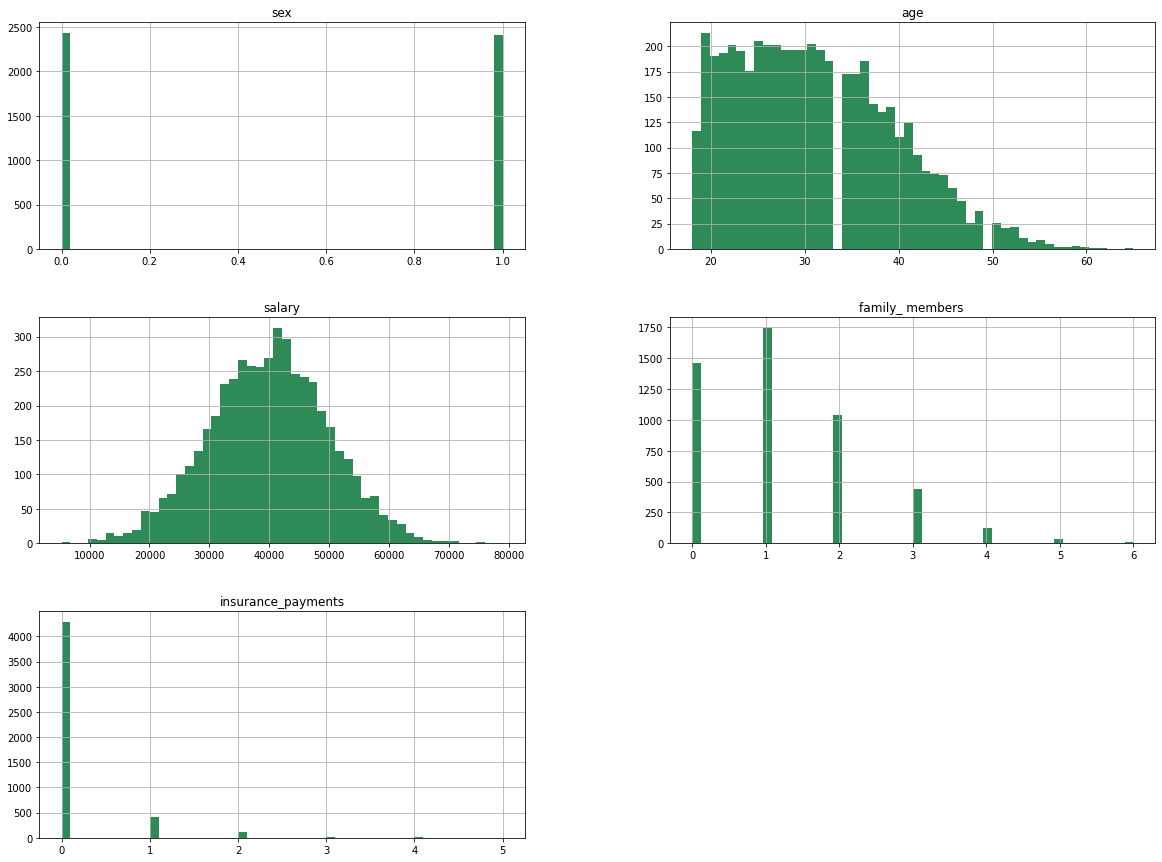

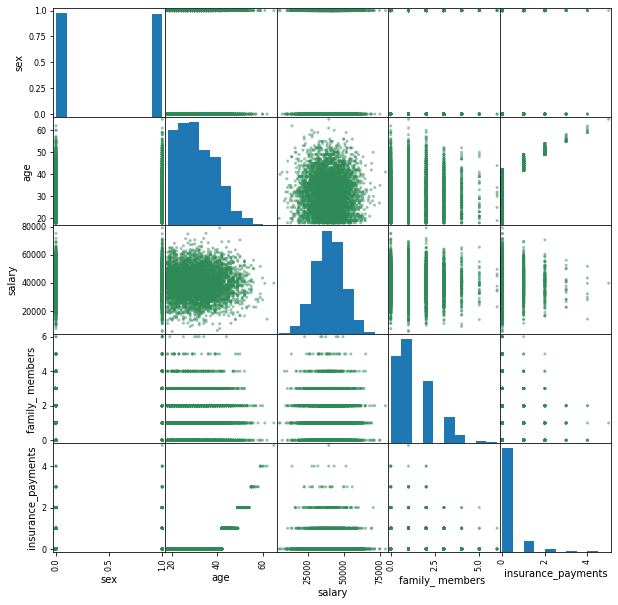

In [7]:
plt.figure(figsize=(20, 16))
data.hist(bins=50, figsize=(20,15), color='seagreen', linewidth=2)
plt.grid()
plt.show()



pd.plotting.scatter_matrix(data, color='seagreen',figsize=(10, 10))
plt.show()

In [8]:
(data.corr(method = 'spearman')
 .sort_values(by = 'insurance_payments', ascending = False)
 .style.background_gradient(cmap = 'coolwarm')
)

,sex,age,salary,family_ members,insurance_payments
insurance_payments,0.000964,0.555655,-0.003878,-0.032201,1.000000
age,-0.000092,1.000000,-0.018972,-0.003414,0.555655
sex,1.000000,-0.000092,0.012079,-0.004594,0.000964
salary,0.012079,-0.018972,1.000000,-0.027361,-0.003878
family_ members,-0.004594,-0.003414,-0.027361,1.000000,-0.032201


### Вывод
* В исходных данных содержится информация о 5000 объектах. 
* Из начальной выборки мы удалили 153 дубликата, таким образом в данных, которые будут использоваться далее, содержится информация о 4847 уникальных объектах.

Мы посмотрели, как рапределяются данные и на степень их корреляции друг с другом:
* количество мужчин и женщин в данных совпадает;
* средняя зарплата лежит в диапазоне от 35 до 45 тыс. рублей;
* средний возраст клиентов составляет 31 год;
* больше всего целевой признак коррелирует с возрастом клиентов;

## Умножение матриц

Убедимся, что умножение признаков на обратимую матрицу не изменяет качество линейной регрессии. Для этого будем использовать следующие обозначения:

- $X$ — матрица признаков (нулевой столбец состоит из единиц)

- $y$ — вектор целевого признака

- $P$ — матрица, на которую умножаются признаки

- $w$ — вектор весов линейной регрессии (нулевой элемент равен сдвигу)

Предсказания:

$$
a = Xw
\tag{1}
$$

Задача обучения:

$$
w = \arg\min_w MSE(Xw, y)
\tag{2}
$$

Формула обучения:

$$
w = (X^T X)^{-1} X^T y
\tag{3}
$$

Раскроем скобки и упростим выражения (1) и (3). Для этого воспользуемся свойствами матриц:

$$
(AB)^{T} = B^{T}A^{T}
\tag{4}
$$

$$
(AB)^{-1} = B^{-1}A^{-1}
\tag{5}
$$

Таким образом получим:
$$ 
w = X^{-1}(X^{T})^{-1}X^{T}y = X^{-1}y
\tag{6}
$$

$$
a = XX^{-1}y = y
\tag{7}
$$

Обозначим через $\hat{X}$ новую матрицу:

$$
\hat{X} = X \cdot P
\tag{8}
$$

Тогда формула обучения (6) примет вид:

$$
\hat{w} = (\hat{X}^{t}\hat{X})^{-1}\hat{X}^{T}y = (P^{T}X^{T}XP)^{-1}P^{T}X^{T}y;
\tag{9}
$$
    
$$
\hat{w} = (P^{T}(X^{T}X)P)^{-1}P^{T}X^{T}y = P^{-1}(P^{T}(X^{T}X))^{-1}P^{T}X^{T}y;
\tag{10}
$$
    
Матрица $X^{T}X$ квадратная, но в общем случае мы также ничего не знаем о ее обратимости. Предположим, что она тоже обратима, тогда:

$$
\hat{w} =  P^{-1}(X^{T}X)^{-1}(P^{T})^{-1}P^{T}X^{T}y = P^{-1}w;
\tag{11}
$$
    
$$
\hat{a} = XPP^{-1}w = Xw;
\tag{12}
$$
    
$$
\hat{a} = a
\tag{13}
$$
Таким образом можно видеть, что $a = \hat{a}$, а значит умножение признаков на обратимую матрицу не изменяет качество линейной регрессии.

## Алгоритм преобразования

**Алгоритм**

Как было показано в предыдущем пункте, умножение признаков на обратимую матрицу не изменяет качество линейной регрессии. Зашифруем данные умножив исходную матрицу признаков на матрицу из больших простых чисел: качество модели не изменится, а восстановить данные без ключа будет не так просто.

Шифрующую матрицу составим из больших простых чисел:

In [9]:
#**************************************
# Определитель простых чисел
#**************************************
def is_prime(num):

    if num == 0 or num == 1:
        return False
    for x in range(2, num):
        if num % x == 0:
            return False
    else:
        return True

In [10]:
#**************************************
# Генератор случайной обратимой матрицы
#**************************************
def matrix_gen(features_shape):
    
    rows = features_shape
    cols =rows
    
    primes = []
    
    inv = False
    

    for i in range(0, rows**2):
        n = 4
        while is_prime(n) == False:
            n = np.random.randint(1e5, 1e7)
        primes.append(n)
    P = np.array(primes).reshape(rows, cols)
    
    if np.linalg.det(P) == 0:
        print('!!! МАТРИЦА НЕОБРАТИМА !!!')
    return P


Разобьем исходную выборку на тренировочную и тестовую:

In [11]:
train, test = train_test_split(data, test_size=0.25, random_state=42)
print(train.shape[0]/data.shape[0])

0.7499484217041469


Определим признаки:

In [12]:
features_train = train.drop('insurance_payments', axis=1)
features_test = test.drop('insurance_payments', axis=1)

target_train = train['insurance_payments']
target_test = test['insurance_payments']

Создадим шифрующую матрицу:

In [13]:
P_train = matrix_gen(features_train.shape[1])

И зашифруем признаки:

In [14]:
features_train_hat = pd.DataFrame(features_train.values @ P_train, columns=features_train.columns)

## Проверка алгоритма

Создадим и обучим модель линейной регрессии на исходных и зашифрованных данных.

In [15]:
model = LinearRegression()

model_crypt = model.fit(features_train_hat, target_train)
model = model.fit(features_train, target_train)

Предскажем целевые признаки и сравним метрики R2 для различных исходных данных:

In [16]:
predictions_crypt = model_crypt.predict(features_test)
predictions = model.predict(features_test)

R2_crypt = r2_score(target_test, predictions_crypt)
R2 = r2_score(target_test, predictions)

print('R2 для зашифровванных данных:{0:0.2};'.format(R2_crypt))
print('R2 для незашифровванных данных:{0:0.2};'.format(R2))
print('Среднее MSE для предсказаний моделей:', mean_squared_error(predictions, predictions_crypt))

R2 для зашифровванных данных:0.44;
R2 для незашифровванных данных:0.44;
Среднее MSE для предсказаний моделей: 0.0


### Вывод

Как и предполагалось, умножение матрицы признаков на шифрующую обратимую матрицу не привело к изменению качества модели.